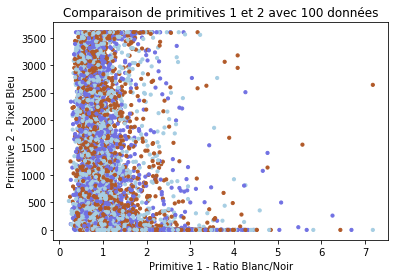

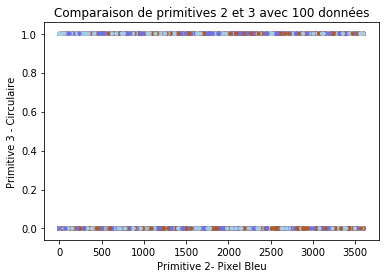

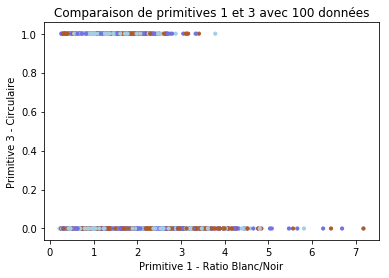

Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = None
0.7939912241347314


Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = 2
0.8154611701981592


Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = 3
0.8173538564115642


Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = 4
0.8249836154347066


Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = 5
0.8280594360491221


Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = 10
0.8256344504222382




In [17]:
# Import des libraries necessaires
# from multiprocessing import Pool
from skimage import io, novice
from PIL import Image
%matplotlib inline   
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import cv2
from pylab import *

#
#
#
#
#------------------Section Extraction de primitives-----------
#
#
#
#

# À modifier pour votre environmement
galaxyLabelFolderLocation = 'C:/Users/N1/Desktop/'
galaxyImagesFolderLocation = 'C:/Users/N1/Desktop/images/'

# Lecture de fichier
fid = open(galaxyLabelFolderLocation + 'galaxy/galaxy/galaxy_label_data_set.csv', 'r') # option r veut dire read
txt = fid.readlines() # Cette ligne permet de lire tout le fichier 
fid.close() # Fermeture de fichier

# Zoom to modify for precision
zoom1=60
zoom2=30
zoom3=100

a=[]  #Smooth list
b=[]  #Spiral list

nbElement = 31000

for element in txt:
    if len(a) > nbElement and len(b) > nbElement:
        break
    else:
        element = element[:-1]
        element = element.split(',')
        if element[1] == 'smooth' and len(a) < nbElement:
            a.append(element)
        if element[1] == 'spiral' and len(b) < nbElement:
            b.append(element)

labels = a + b
labels = np.array(labels)

#Données brut de nos images
rawData = []

for element in labels:
    img1 = novice.open(galaxyImagesFolderLocation + element[0] +'.jpg') #Chemin a votre image de galaxie

    #Croping     
    y=img1.width
    x=img1.height
    startx1 = y//2-(zoom1//2)
    starty1 = x//2-(zoom1//2)    
    startx2 = y//2-(zoom2//2)
    starty2 = x//2-(zoom2//2)
    startx3 = y//2-(zoom3//2)
    starty3 = x//2-(zoom3//2)
    img21=(img1[starty1:starty1+zoom1,startx1:startx1+zoom1])
    img22=(img1[starty2:starty2+zoom2,startx2:startx2+zoom2])
    img23=(img1[starty3:starty3+zoom3,startx3:startx3+zoom3])
    
    redCount = 0
    blueCount = 0
    
    #For Color Ratio
    for pixel in img21:
        if (pixel.red > pixel.blue):
            redCount = redCount + 1
        else:
            blueCount = blueCount + 1
    
    #For Black and White ratio
    
    img3 = img22.rgb
    img4 = Image.fromarray(img3)
    img5 = img4.convert('1')
    img6 = np.array(img5)
    img7 = np.unique(img6,return_counts=True)
    img8 = img7[1]

    #Number of pixels
    blackCount = img8[0]
    whiteCount = img8[1]
    
    #Circular
    
    img9 = img23.rgb
    img10 = Image.fromarray(img9)
    img11 = np.array(img10) 
    img12 = img11[:, :, ::-1].copy() 
    img13 = cv2.cvtColor(img12,cv2.COLOR_BGR2GRAY)

    all_circs = cv2.HoughCircles(img13, cv2.HOUGH_GRADIENT, 0.9,200,param1=50,param2=30,minRadius=30,maxRadius=100)

    circular = 0
    if isinstance(all_circs,ndarray):
        circular=1
    else:
        circular=0
    
    #Number of the galaxy, number of black pixel, number of white pixel, red pixels and blue pixels
    rawData.append([element[0], blackCount, whiteCount, redCount, blueCount, circular])
    
featureVector=[]
for element in rawData:
    black=element[2]
    white=element[1]
    blue=element[4]
    red=element[3]
    circular=element[5]
    
    ratio=(black/white)
    ratioBR = (blueCount/redCount)
  
    
    featureVector.append([ratio,blue,circular])

# On peut essayer de normalizer nos données avec un z-score s'ils donnent des valeurs vraiment folles
# from scipy import stats
# stats.zscore(featureVector[:,1]) -> pour normaliser les ratiospar example


#
#
#
#
#------------------Section Graphiques-----------------------
#
#
#
#

# Chargement des donnees remplace iris.data avec nos primitives et replace iris.target avec nos étiquettes
iris = load_iris()

color1=(0.69411766529083252, 0.3490196168422699, 0.15686275064945221, 1.0) # Couleur des spiral
color2=(0.65098041296005249, 0.80784314870834351, 0.89019608497619629, 1.0) # Couleur des smooth
color3=(0.44444444965155249, 0.44444444445834351, 0.89044444444477777, 1.0) # Troixieme uniquement pour la BD iris de test, on l'enlève lorsqu'on a plus de besoin

colormap = np.array([color1,color2,color3])


def column(matrix, i):
    return [row[i] for row in matrix]

# Premier Graphique

x = column(featureVector, 0)
y = column(featureVector, 1)

# X DOIT ETRE PRIMITIVE 1 
# Y PRIMITIVE 2 
# IRIS.TARGET NOS CLASSES
plt.scatter(x, y, s=10, c=colormap[iris.target])

plt.title('Comparaison de primitives 1 et 2 avec 100 données')
plt.xlabel('Primitive 1 - Ratio Blanc/Noir')
plt.ylabel('Primitive 2 - Pixel Bleu')
plt.show()

# Deuxieme graphique
x = column(featureVector, 1)
y = column(featureVector, 2)

plt.scatter(x, y, s=10, c=colormap[iris.target])

plt.title('Comparaison de primitives 2 et 3 avec 100 données')
plt.xlabel('Primitive 2- Pixel Bleu')
plt.ylabel('Primitive 3 - Circulaire')
plt.show()

#Troixieme graphique
x = column(featureVector, 0)
y = column(featureVector, 2)

plt.scatter(x, y, s=10, c=colormap[iris.target])

plt.title('Comparaison de primitives 1 et 3 avec 100 données')
plt.xlabel('Primitive 1 - Ratio Blanc/Noir')
plt.ylabel('Primitive 3 - Circulaire')
plt.show()
    
#
#
#
#
#------------------Section Apprentissage---------------------
#
#
#
#

destrees = [0, 2, 3, 4 ,5, 10]

# Chargement des donnees remplace iris.data avec nos primitives et replace iris.target avec nos étiquettes
iris = load_iris()

# Creation de nos arbres de decision en utilisant l'entropie et un max_depth variable
def decisionClassifyWithDepth(depth, data, target):
    if depth == 0:
        desTree = tree.DecisionTreeClassifier(criterion='entropy')
        depth = "None"
    else:
        desTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    
    # Apprentissage avec la fonction fit
    desTree = desTree.fit(data, target)

    # CrossVal Score
    print("Moyenne des scores CrossVal 5fold : Arbe de décision max_depth = " + str(depth))
    print(np.mean(np.array(cross_val_score(desTree, data, target, cv=5))))
    print('\n')


for element in destrees:
    
    # iris.data[:, :3] veut dire qu'on utilise la totalite des "rows" et seulement 3 colonnes [:, 3]
    # pour utiliser seulement 3 "rows" et la totalite des colonnes on utilise [:3, :]
    decisionClassifyWithDepth(element, featureVector, labels[:, 1:2])
    
    
    # Démarrage des processus en parallèle
    # print(pool.map(decisionClassifyWithDepth, (destrees, ))